# Import Library

In [142]:
import numpy as np
import  pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

# Data Preparation

In [143]:
#load data
df_store = pd.read_csv('store5.csv')

In [144]:
#melihat 10 data 10 baris
df_store.head(10)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.0,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.0,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.0,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.0,0,NaN
4,1456,2013-01-01,5,BOOKS,0.0,0,NaN
5,1457,2013-01-01,5,BREAD/BAKERY,0.0,0,NaN
6,1458,2013-01-01,5,CELEBRATION,0.0,0,NaN
7,1459,2013-01-01,5,CLEANING,0.0,0,NaN
8,1460,2013-01-01,5,DAIRY,0.0,0,NaN
9,1461,2013-01-01,5,DELI,0.0,0,NaN


In [145]:
#mengecek info df_store
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           55572 non-null  int64  
 1   date         55572 non-null  object 
 2   store_nbr    55572 non-null  int64  
 3   family       55572 non-null  object 
 4   sales        55572 non-null  float64
 5   onpromotion  55572 non-null  int64  
 6   dcoilwtico   38379 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.0+ MB


In [146]:
df_store.isnull().sum()

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
dcoilwtico     17193
dtype: int64

data dcoilwtico memiliki 0.309382 data kosong 

In [147]:
df_store['family'].value_counts()

family
AUTOMOTIVE                    1684
HOME APPLIANCES               1684
SCHOOL AND OFFICE SUPPLIES    1684
PRODUCE                       1684
PREPARED FOODS                1684
POULTRY                       1684
PLAYERS AND ELECTRONICS       1684
PET SUPPLIES                  1684
PERSONAL CARE                 1684
MEATS                         1684
MAGAZINES                     1684
LIQUOR,WINE,BEER              1684
LINGERIE                      1684
LAWN AND GARDEN               1684
LADIESWEAR                    1684
HOME CARE                     1684
HOME AND KITCHEN II           1684
BABY CARE                     1684
HOME AND KITCHEN I            1684
HARDWARE                      1684
GROCERY II                    1684
GROCERY I                     1684
FROZEN FOODS                  1684
EGGS                          1684
DELI                          1684
DAIRY                         1684
CLEANING                      1684
CELEBRATION                   1684
BREAD/BAKERY 

In [148]:
#Membuang tabel store_nbr dan id
df_store.drop(['id', 'store_nbr'], axis=1, inplace=True)
df_copy = df_store.copy()

In [149]:
#Mengubah tipe data kolom date menjadi date time
df_store['date'] = pd.to_datetime(df_copy['date'])

In [150]:
#mengurutkan data berdasarkan tanggal
df_store = df_store.set_index('date')
df_store

,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,AUTOMOTIVE,0.000,0,NaN
2013-01-01,BABY CARE,0.000,0,NaN
2013-01-01,BEAUTY,0.000,0,NaN
2013-01-01,BEVERAGES,0.000,0,NaN
2013-01-01,BOOKS,0.000,0,NaN
...,...,...,...,...
2017-08-15,POULTRY,241.011,1,47.57
2017-08-15,PREPARED FOODS,52.121,0,47.57
2017-08-15,PRODUCE,1357.823,4,47.57


#### *tabel id dan store_nbr sudah hilang*

# EDA (Exploratory Data Analysis)

<function matplotlib.pyplot.show(close=None, block=None)>

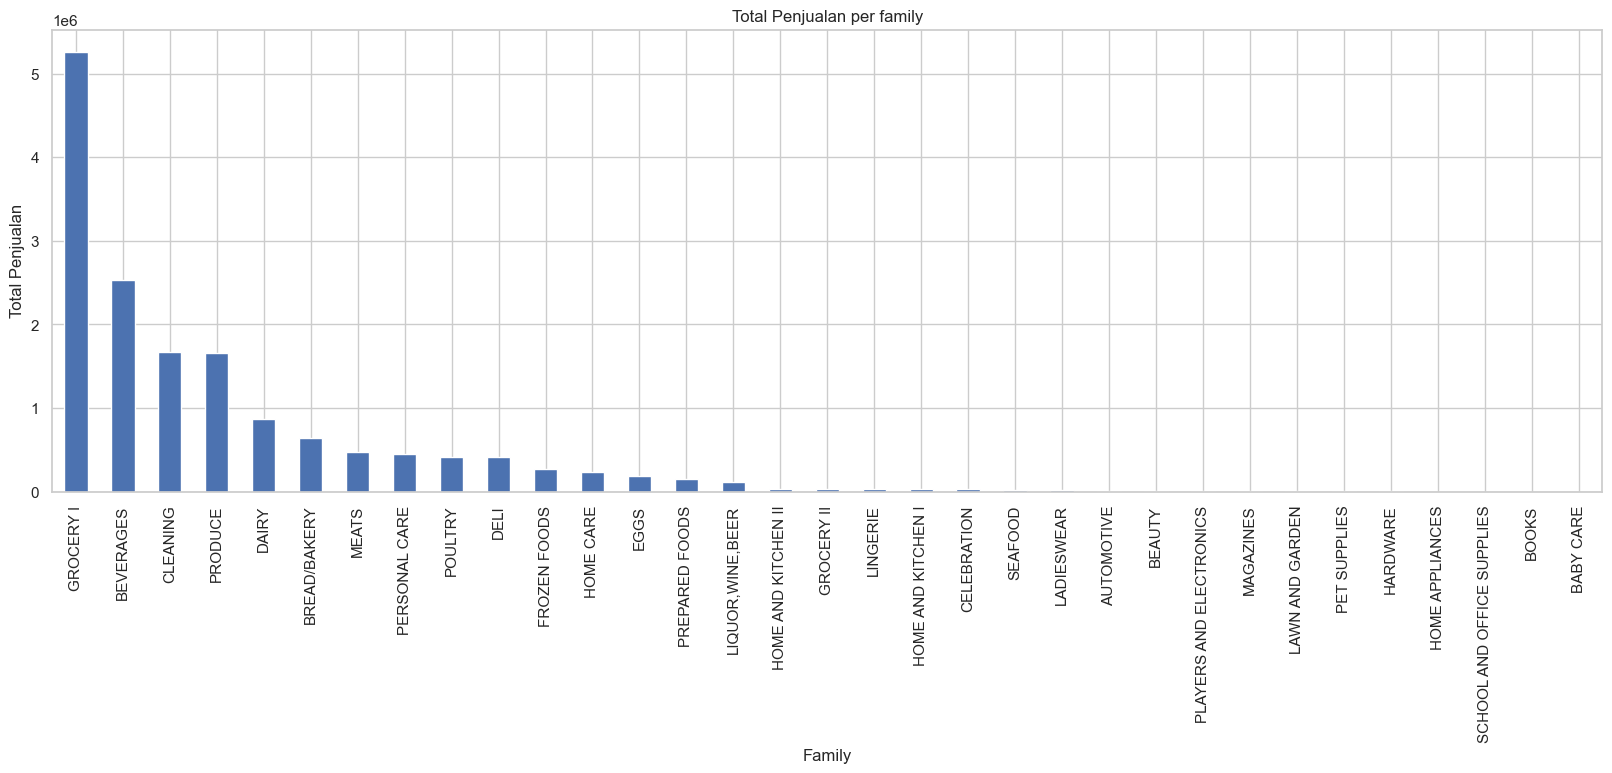

In [151]:
#melihat data total penjualan 
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')

#menghitung data penjualan per family
df_store.groupby('family')['sales'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Total Penjualan per family')
plt.xlabel('Family')
plt.ylabel('Total Penjualan')
plt.show

In [152]:
#melihat data penjualan baverages
beverage = df_store['family']=='BEVERAGES'
beverage = df_store[beverage]
beverage

,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,BEVERAGES,0.0,0,NaN
2013-01-02,BEVERAGES,947.0,0,93.14
2013-01-03,BEVERAGES,847.0,0,92.97
2013-01-04,BEVERAGES,859.0,0,93.12
2013-01-05,BEVERAGES,912.0,0,NaN
...,...,...,...,...
2017-08-11,BEVERAGES,1717.0,11,48.81
2017-08-12,BEVERAGES,1353.0,6,NaN
2017-08-13,BEVERAGES,1838.0,9,NaN


In [153]:
beverage.describe()

,sales,onpromotion,dcoilwtico
count,1684.000000,1684.000000,1163.000000
mean,1504.650238,10.934086,67.925589
std,669.041806,15.896720,25.677366
min,0.000000,0.000000,26.190000
25%,850.750000,0.000000,46.390000
50%,1562.000000,3.000000,53.330000
75%,1956.500000,16.000000,95.790000
max,3796.000000,93.000000,110.620000


### Describe family baverage Tabel Sales

<Figure size 2000x600 with 0 Axes>

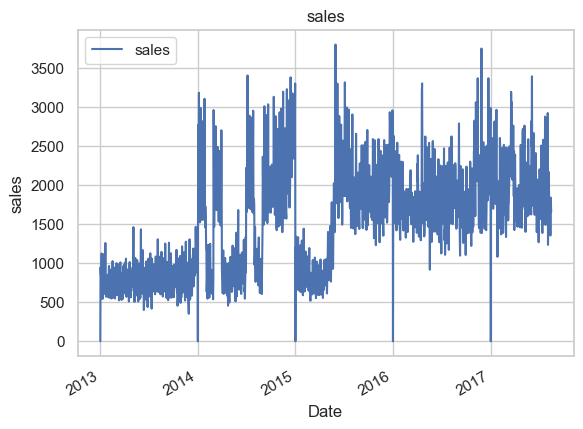

In [154]:
#Melihat data penjualan dan membuatnya menjadi dataset terpisah dan mengubah indexnya
sales = df_store['family']=='BEVERAGES'
sales = df_store[sales]
sales = sales[['sales']]

#melihat plot sales
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')
sales.plot()
plt.title('sales')
plt.xlabel('Date')
plt.ylabel('sales')
plt.show()

### Describe family baverage Tabel dcoilwtico

<Figure size 2000x600 with 0 Axes>

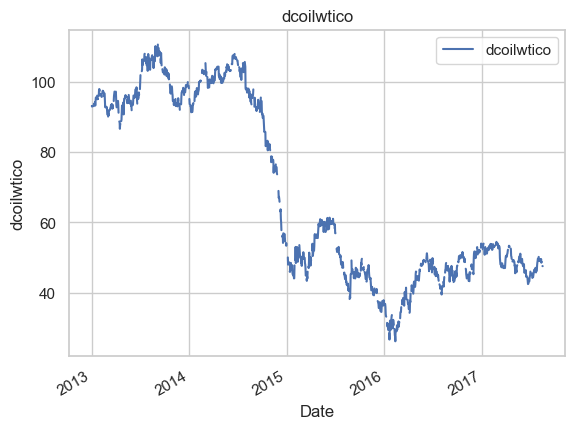

In [155]:
#Melihat dcoilwtico dan membuatnya menjadi dataset terpisah dan mengubah indexnya
dcoilwtico = df_store['family']=='BEVERAGES'
dcoilwtico = df_store[dcoilwtico]
dcoilwtico = dcoilwtico[['dcoilwtico']]

#melihat plot dcoilwtico
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')
dcoilwtico.plot()
plt.title('dcoilwtico')
plt.xlabel('Date')
plt.ylabel('dcoilwtico')
plt.show()

#### *garis dcoilwtico terlihat putus karena banyak deret waktu yang kosong*

#### Describe family baverage Tabel onpromotion

<Figure size 2000x600 with 0 Axes>

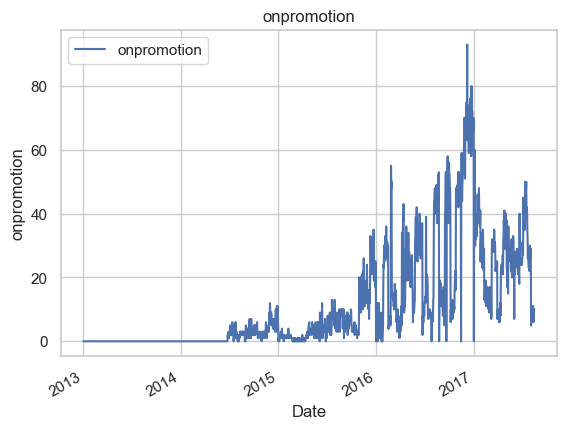

In [156]:
#Melihat onpromotion dan membuatnya menjadi dataset terpisah dan mengubah indexnya
onpromotion = df_store['family']=='BEVERAGES'
onpromotion = df_store[onpromotion]
onpromotion= onpromotion[['onpromotion']]

#melihat plot onpromotion
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')
onpromotion.plot()
plt.title('onpromotion')
plt.xlabel('Date')
plt.ylabel('onpromotion')
plt.show()

<br>

# EDA per family

In [157]:
#mengambil data penjualan untuk famil
beverage = df_store['family']=='BEVERAGES'
beverage = df_store[beverage]
beverage.drop(['family'], axis=1, inplace=True)
beverage

C:\Users\sahab\AppData\Local\Temp\ipykernel_6848\2489400395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beverage.drop(['family'], axis=1, inplace=True)


,sales,onpromotion,dcoilwtico
date,,,
2013-01-01,0.0,0,NaN
2013-01-02,947.0,0,93.14
2013-01-03,847.0,0,92.97
2013-01-04,859.0,0,93.12
2013-01-05,912.0,0,NaN
...,...,...,...
2017-08-11,1717.0,11,48.81
2017-08-12,1353.0,6,NaN
2017-08-13,1838.0,9,NaN


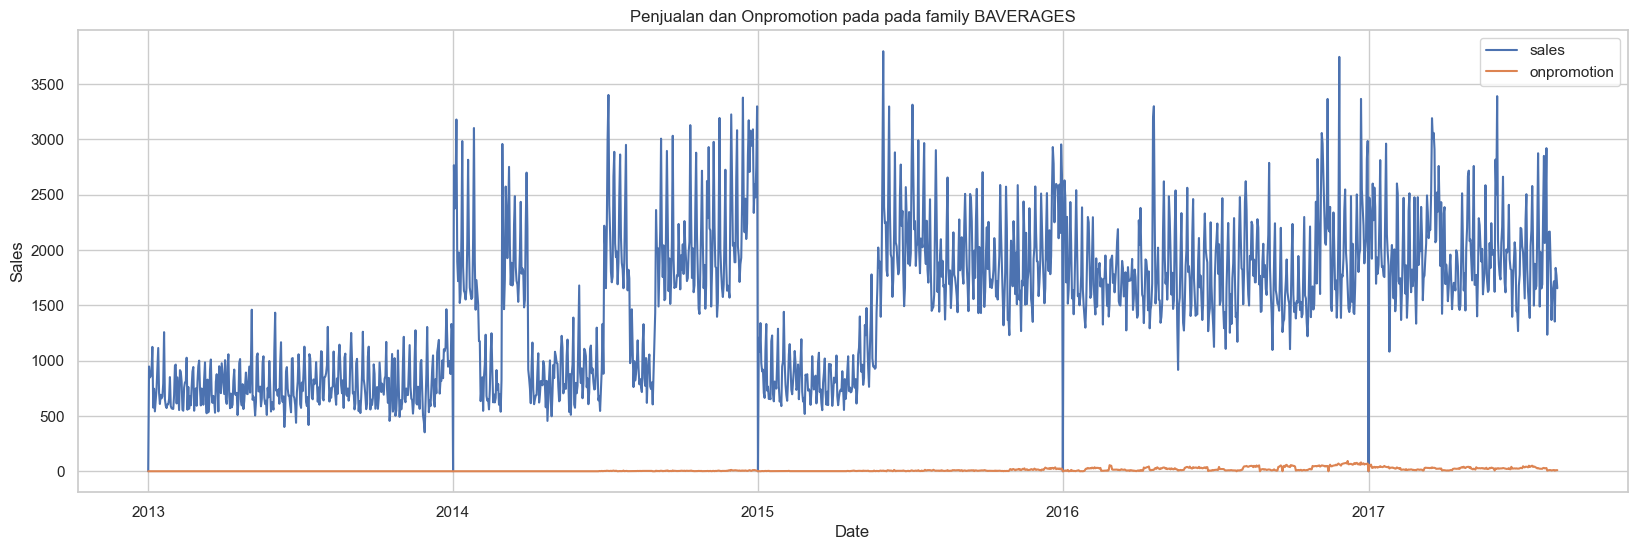

In [158]:
#Melihat penjualan dan onpromotion pada family BAVERAGES
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')
sns.lineplot(data=beverage, x='date', y='sales', label='sales')
sns.lineplot(data=beverage, x='date', y='onpromotion', label='onpromotion')
plt.title('Penjualan dan Onpromotion pada pada family BAVERAGES')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

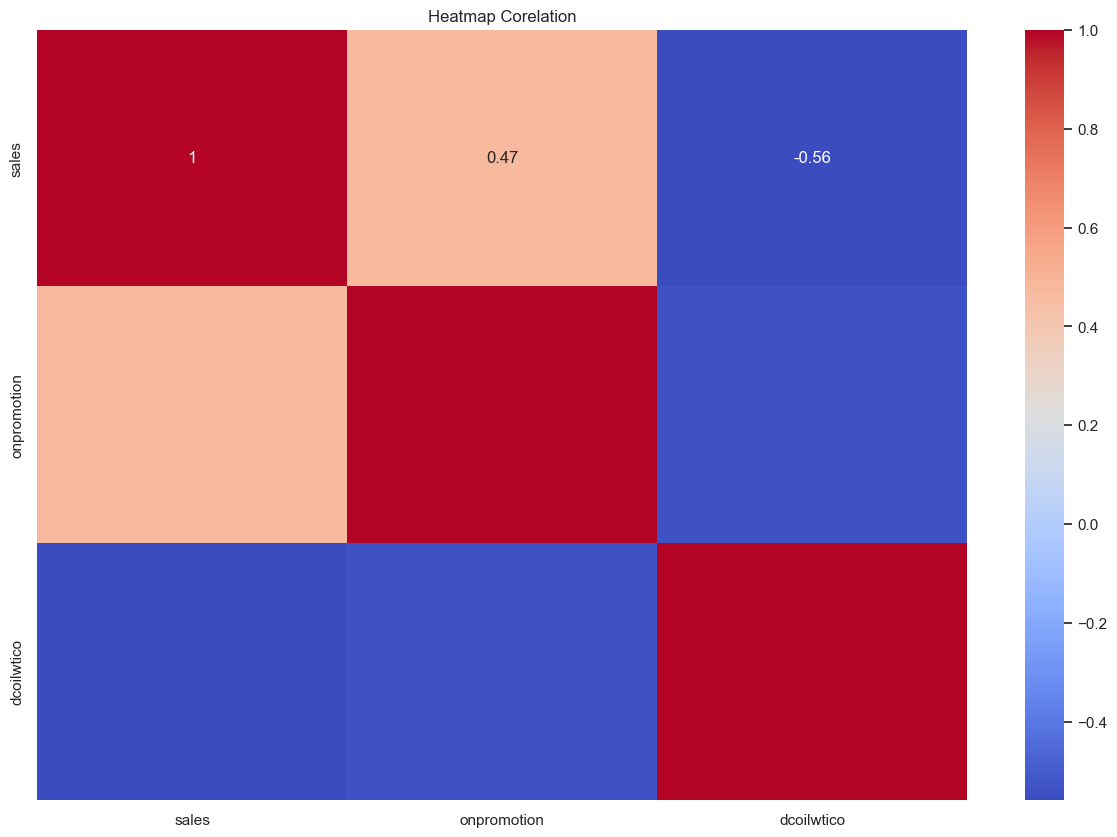

In [159]:
# Menggunakan metode pearsing correlation untuk melihat korelasi antar variabel
beverage.corr(method='pearson')

# Membuat heatmap dari coorelation
plt.figure(figsize=(15,10))
sns.heatmap(beverage.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap Corelation')
plt.show()

<Axes: xlabel='date'>

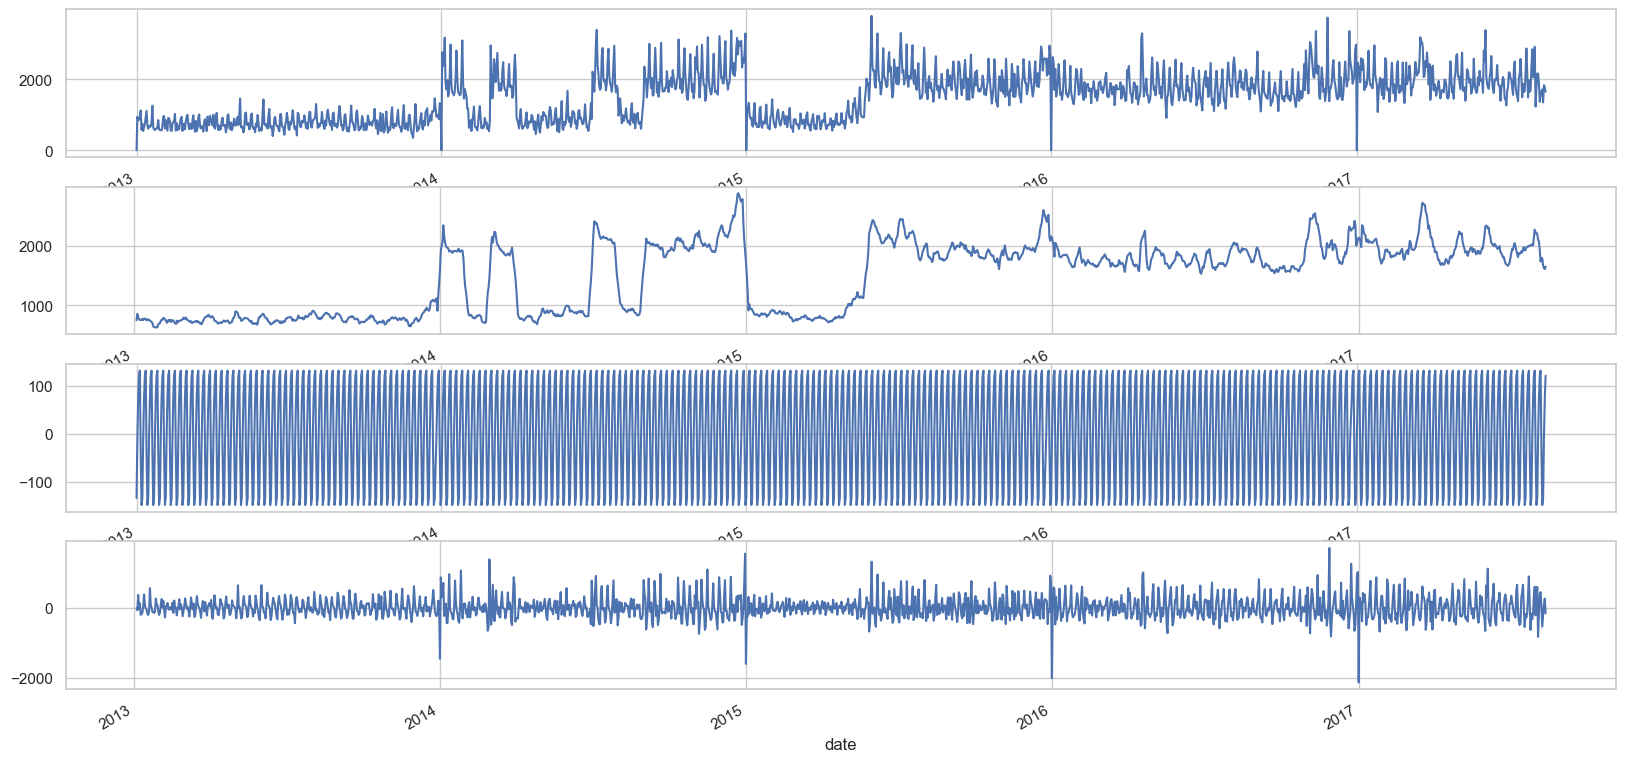

In [160]:
#melihat data transactions dengan decompose durasi 1 pekan
decompose_plot = seasonal_decompose(beverage['sales'], model='additive', period=7)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20,10))
decompose_plot.observed.plot(ax=ax1)
decompose_plot.trend.plot(ax=ax2)
decompose_plot.seasonal.plot(ax=ax3)
decompose_plot.resid.plot(ax=ax4)

<Axes: xlabel='date'>

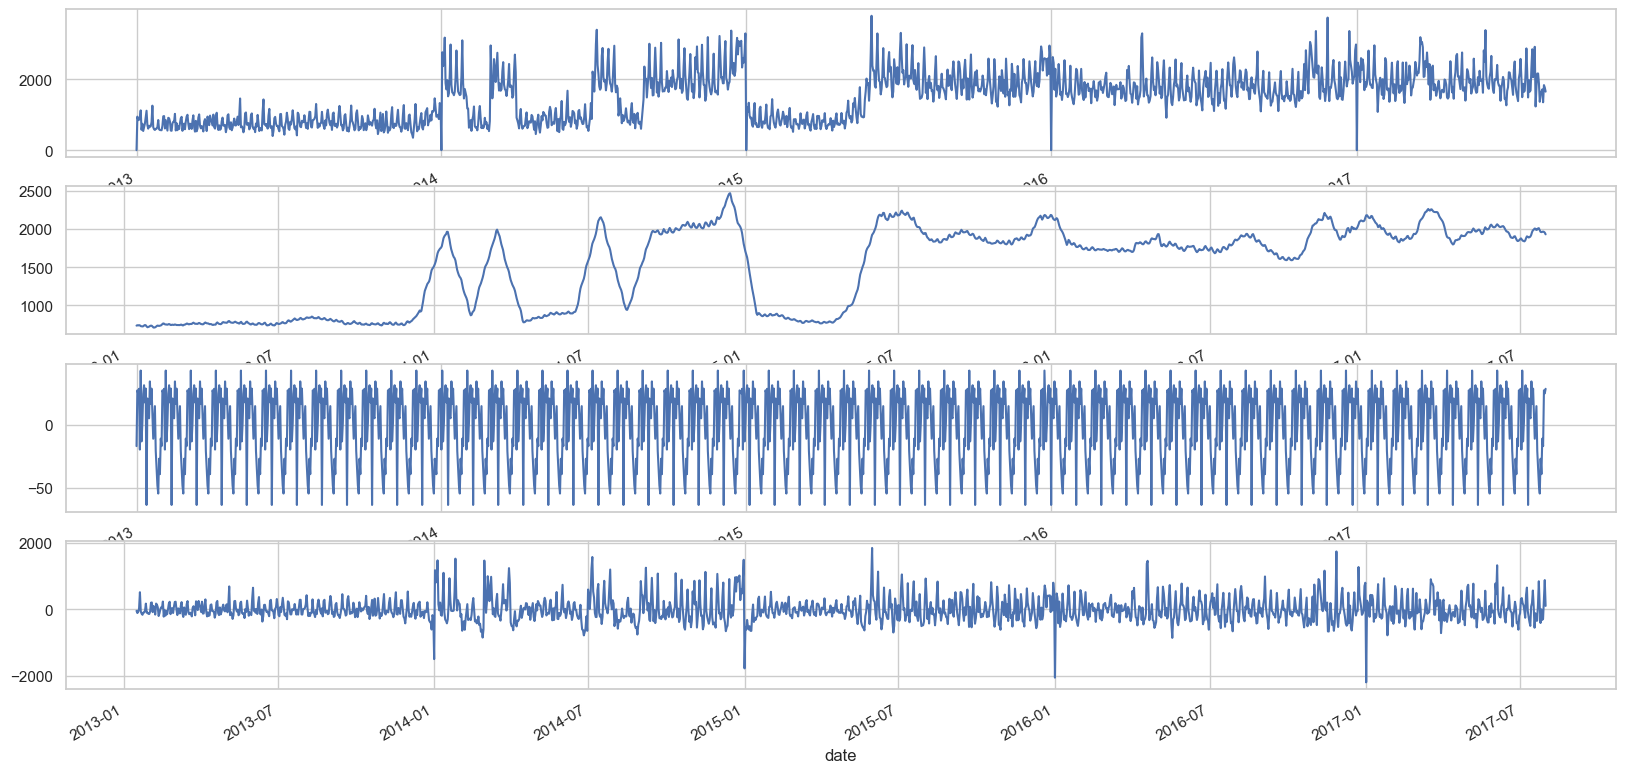

In [161]:
#melihat data transactions dengan decompose durasi 1 bulan
decompose_plot = seasonal_decompose(beverage['sales'], model='additive', period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20,10))
decompose_plot.observed.plot(ax=ax1)
decompose_plot.trend.plot(ax=ax2)
decompose_plot.seasonal.plot(ax=ax3)
decompose_plot.resid.plot(ax=ax4)

<Axes: xlabel='date'>

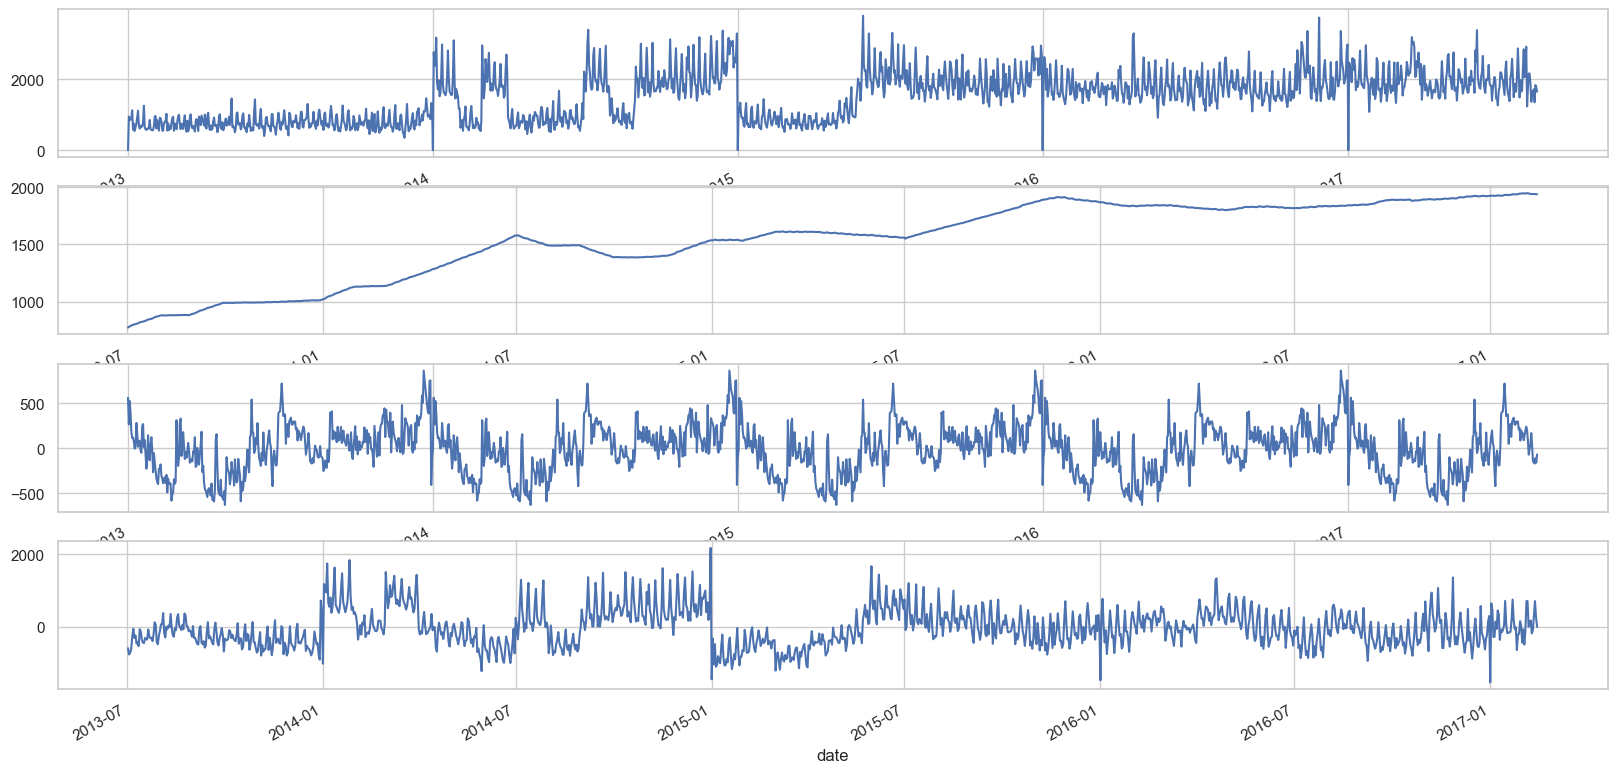

In [162]:
#melihat data transactions dengan decompose durasi 1 bulan
decompose_plot = seasonal_decompose(beverage['sales'], model='additive', period=365)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20,10))
decompose_plot.observed.plot(ax=ax1)
decompose_plot.trend.plot(ax=ax2)
decompose_plot.seasonal.plot(ax=ax3)
decompose_plot.resid.plot(ax=ax4)

In [163]:
#mengimpor model adfuller
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(beverage['sales'].dropna())
print('ADF statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF statistic: -3.853390
p-value: 0.002406


*nilai -3.853390 adfuller ini menunjukkan jika data beverage belum stationer, dikatakn stationer harus dibawah 0.05*

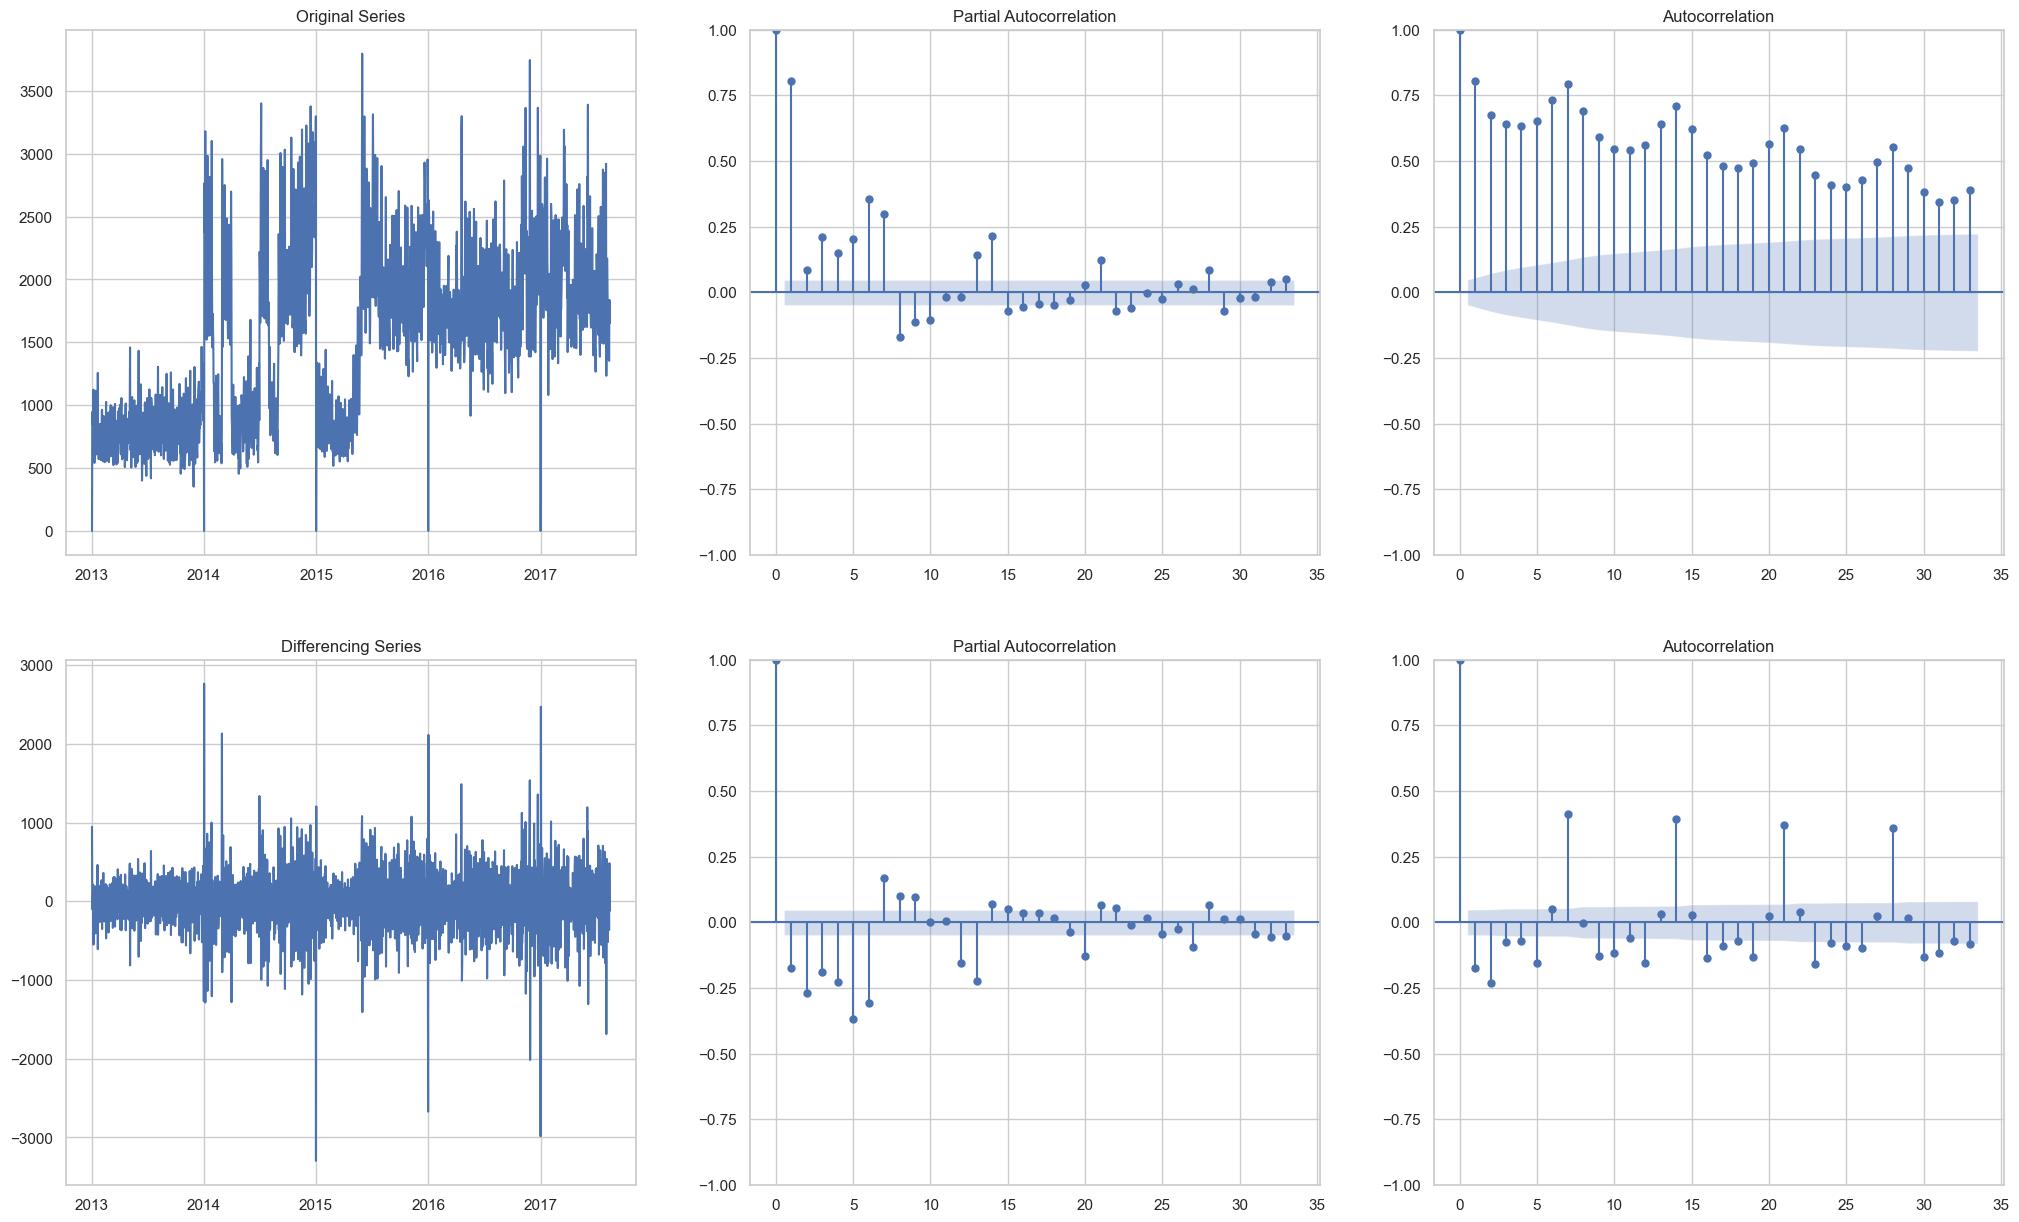

In [164]:
#membuat plot ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 3, figsize=(25, 15))

ax[0, 0].set_title('Original Series')
ax[0, 0].plot(beverage['sales'])
ax[0, 1] = plot_pacf(beverage['sales'], ax=ax[0, 1])
ax[0, 2] = plot_acf(beverage['sales'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(beverage['sales'].diff().dropna())
ax[1, 1] = plot_pacf(beverage['sales'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(beverage['sales'].diff().dropna(), ax=ax[1, 2])

plt.show()

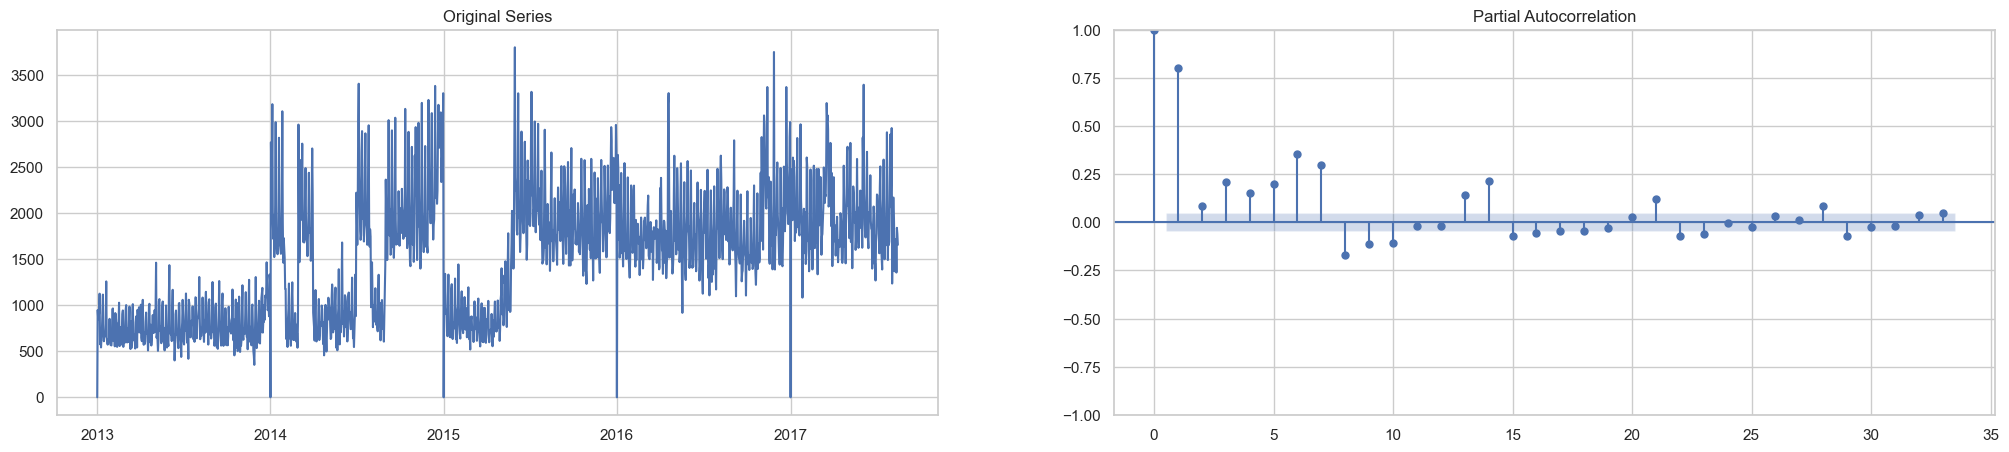

In [165]:
# PACF plot of 1st differenced series

fig,
fig, axes = plt.subplots(1, 2, figsize=(25,5))
axes[0].plot(beverage['sales']); axes[0].set_title('Original Series')
axes[1].set(ylim=(0,5))
plot_pacf(beverage['sales'].dropna(), ax=axes[1])

plt.show()

<br>

# Feature Engineering

In [166]:
#Membagi data fitur beverage berdasarkan tahun, bulan, minggu, hari, dan hari dalam seminggu
cal_beverage = beverage.copy()
cal_beverage.loc[:, 'year'] = beverage.index.year
cal_beverage.loc[:, 'month'] = beverage.index.month
cal_beverage.loc[:, 'day'] = beverage.index.day
cal_beverage.loc[:, 'dayofweek'] = beverage.index.dayofweek

cal_beverage

,sales,onpromotion,dcoilwtico,year,month,day,dayofweek
date,,,,,,,
2013-01-01,0.0,0,NaN,2013,1,1,1
2013-01-02,947.0,0,93.14,2013,1,2,2
2013-01-03,847.0,0,92.97,2013,1,3,3
2013-01-04,859.0,0,93.12,2013,1,4,4
2013-01-05,912.0,0,NaN,2013,1,5,5
...,...,...,...,...,...,...,...
2017-08-11,1717.0,11,48.81,2017,8,11,4
2017-08-12,1353.0,6,NaN,2017,8,12,5
2017-08-13,1838.0,9,NaN,2017,8,13,6


In [167]:
# Menambahkan nilai pada index pertama dcoilwtico
cal_beverage['dcoilwtico'] = cal_beverage['dcoilwtico'].fillna(method='ffill')
cal_beverage

,sales,onpromotion,dcoilwtico,year,month,day,dayofweek
date,,,,,,,
2013-01-01,0.0,0,NaN,2013,1,1,1
2013-01-02,947.0,0,93.14,2013,1,2,2
2013-01-03,847.0,0,92.97,2013,1,3,3
2013-01-04,859.0,0,93.12,2013,1,4,4
2013-01-05,912.0,0,93.12,2013,1,5,5
...,...,...,...,...,...,...,...
2017-08-11,1717.0,11,48.81,2017,8,11,4
2017-08-12,1353.0,6,48.81,2017,8,12,5
2017-08-13,1838.0,9,48.81,2017,8,13,6


In [168]:
#check nilai dcoilwtico
cal_beverage.isnull().sum()

sales          0
onpromotion    0
dcoilwtico     1
year           0
month          0
day            0
dayofweek      0
dtype: int64

In [169]:
cal_beverage['dcoilwtico'] = cal_beverage['dcoilwtico'].fillna(method='bfill')
cal_beverage

,sales,onpromotion,dcoilwtico,year,month,day,dayofweek
date,,,,,,,
2013-01-01,0.0,0,93.14,2013,1,1,1
2013-01-02,947.0,0,93.14,2013,1,2,2
2013-01-03,847.0,0,92.97,2013,1,3,3
2013-01-04,859.0,0,93.12,2013,1,4,4
2013-01-05,912.0,0,93.12,2013,1,5,5
...,...,...,...,...,...,...,...
2017-08-11,1717.0,11,48.81,2017,8,11,4
2017-08-12,1353.0,6,48.81,2017,8,12,5
2017-08-13,1838.0,9,48.81,2017,8,13,6


In [170]:
# Menambahkan rolling window mean pada sales sepanjang 7 hari
cal_beverage['sales_mean_7'] = cal_beverage['sales'].rolling(window=7).mean()
# Menambahkan rolling window mean pada sales sepanjang 30 hari
cal_beverage['sales_mean_30'] = cal_beverage['sales'].rolling(window=30).mean()

cal_beverage

,sales,onpromotion,dcoilwtico,year,month,day,dayofweek,sales_mean_7,sales_mean_30
date,,,,,,,,,
2013-01-01,0.0,0,93.14,2013,1,1,1,NaN,NaN
2013-01-02,947.0,0,93.14,2013,1,2,2,NaN,NaN
2013-01-03,847.0,0,92.97,2013,1,3,3,NaN,NaN
2013-01-04,859.0,0,93.12,2013,1,4,4,NaN,NaN
2013-01-05,912.0,0,93.12,2013,1,5,5,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2017-08-11,1717.0,11,48.81,2017,8,11,4,1790.142857,1967.333333
2017-08-12,1353.0,6,48.81,2017,8,12,5,1674.285714,1966.233333
2017-08-13,1838.0,9,48.81,2017,8,13,6,1627.428571,1959.666667


In [171]:
# Split data menjadi data training dan data testing
train = cal_beverage[:-30]
test = cal_beverage[-30:]
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (1654, 9)
Test shape: (30, 9)


<br>

# Modeling

## Model SARIMA (p,d,q)

In [172]:
from statsmodels.tsa.arima.model import ARIMA

In [173]:
mod_sarima = ARIMA(cal_beverage['sales'], order=(1,1,6), seasonal_order=(1,1,6,7))
mod_fit = mod_sarima.fit()
print(mod_fit.summary())

D:\LUTFI\Anacnda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\LUTFI\Anacnda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\LUTFI\Anacnda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\LUTFI\Anacnda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                    
Dep. Variable:                           sales   No. Observations:                 1684
Model:             ARIMA(1, 1, 6)x(1, 1, 6, 7)   Log Likelihood              -11988.622
Date:                         Mon, 18 Mar 2024   AIC                          24007.245
Time:                                 14:20:03   BIC                          24088.607
Sample:                                      0   HQIC                         24037.387
                                        - 1684                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9897      0.059    -16.784      0.000      -1.105      -0.874
ma.L1          0.4817      0.059      8.140      0.000     

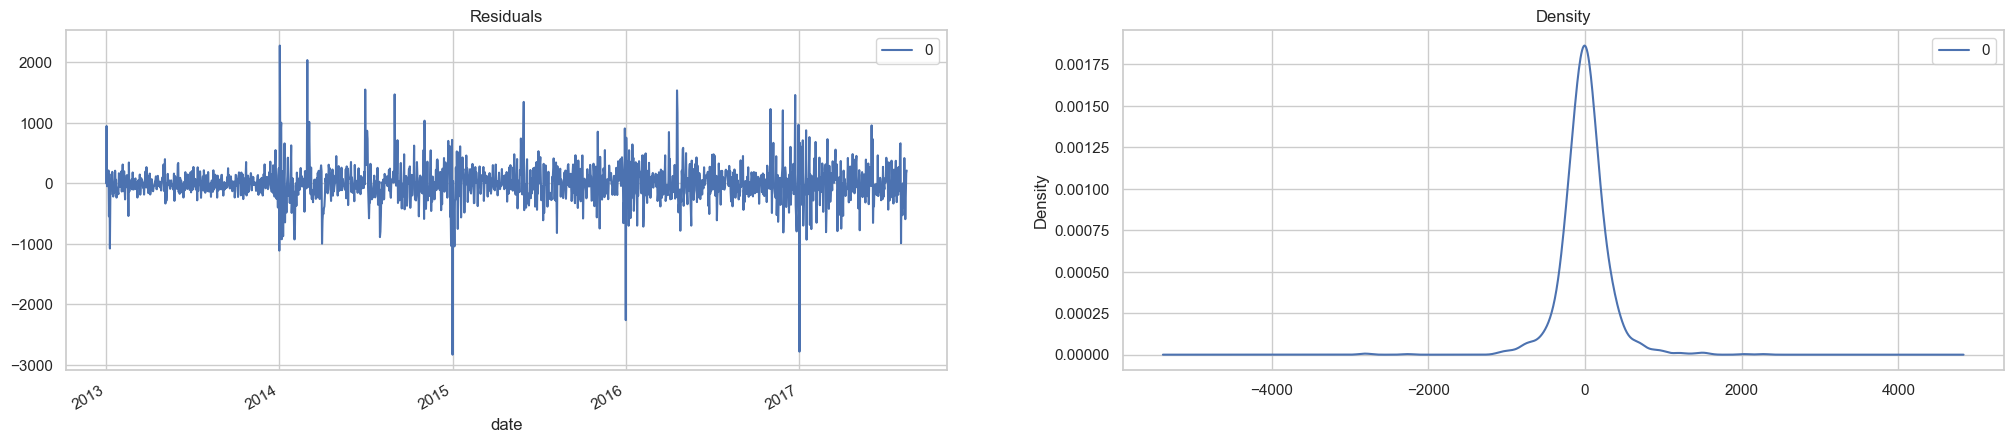

In [174]:
# Plot residual errors
residuals = pd.DataFrame(mod_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

D:\LUTFI\Anacnda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\LUTFI\Anacnda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
D:\LUTFI\Anacnda\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


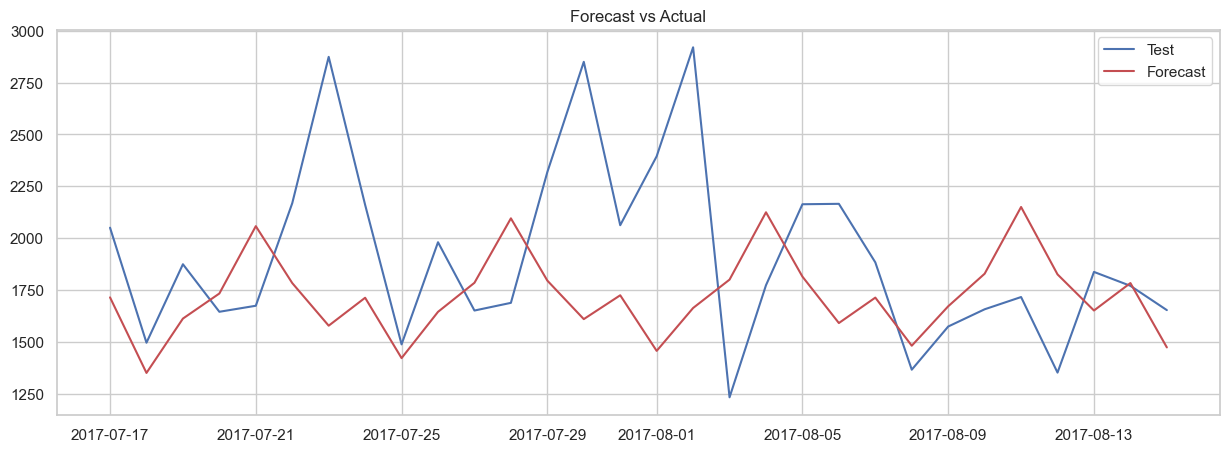

In [175]:
# Prediction
exog_forecast = test['onpromotion'] 
forecast = mod_fit_sarima.predict(start=len(cal_beverage), end=len(cal_beverage)+len(test)-1, typ='levels')
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test['sales'], label='Test')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

In [176]:
# check forecast row
forecastSARIMAX = pd.DataFrame({'test': test['sales'], 'forecast': forecast})
forecastSARIMAX

,test,forecast
date,,
2017-07-17,2051.0,1715.290553
2017-07-18,1497.0,1351.424092
2017-07-19,1875.0,1613.229644
2017-07-20,1646.0,1734.073800
2017-07-21,1675.0,2058.391172
2017-07-22,2169.0,1784.284378
2017-07-23,2874.0,1579.041886
2017-07-24,2161.0,1713.562867
2017-07-25,1489.0,1422.833620


<br>

### Model SARIMA

In [177]:
#seasonal ARIMA
mod_sarima = ARIMA(cal_beverage['sales'], order=(6,0,2), seasonal_order=(6, 0, 2, 7))
mod_fit_sarima = mod_sarima.fit()
print(mod_fit_sarima.summary())

D:\LUTFI\Anacnda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\LUTFI\Anacnda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\LUTFI\Anacnda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\LUTFI\Anacnda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                    
Dep. Variable:                           sales   No. Observations:                 1684
Model:             ARIMA(6, 0, 2)x(6, 0, 2, 7)   Log Likelihood              -12034.413
Date:                         Mon, 18 Mar 2024   AIC                          24104.826
Time:                                 14:20:50   BIC                          24202.547
Sample:                                      0   HQIC                         24141.020
                                        - 1684                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1504.6472    274.334      5.485      0.000     966.963    2042.332
ar.L1         -0.7900      0.123     -6.408      0.000     

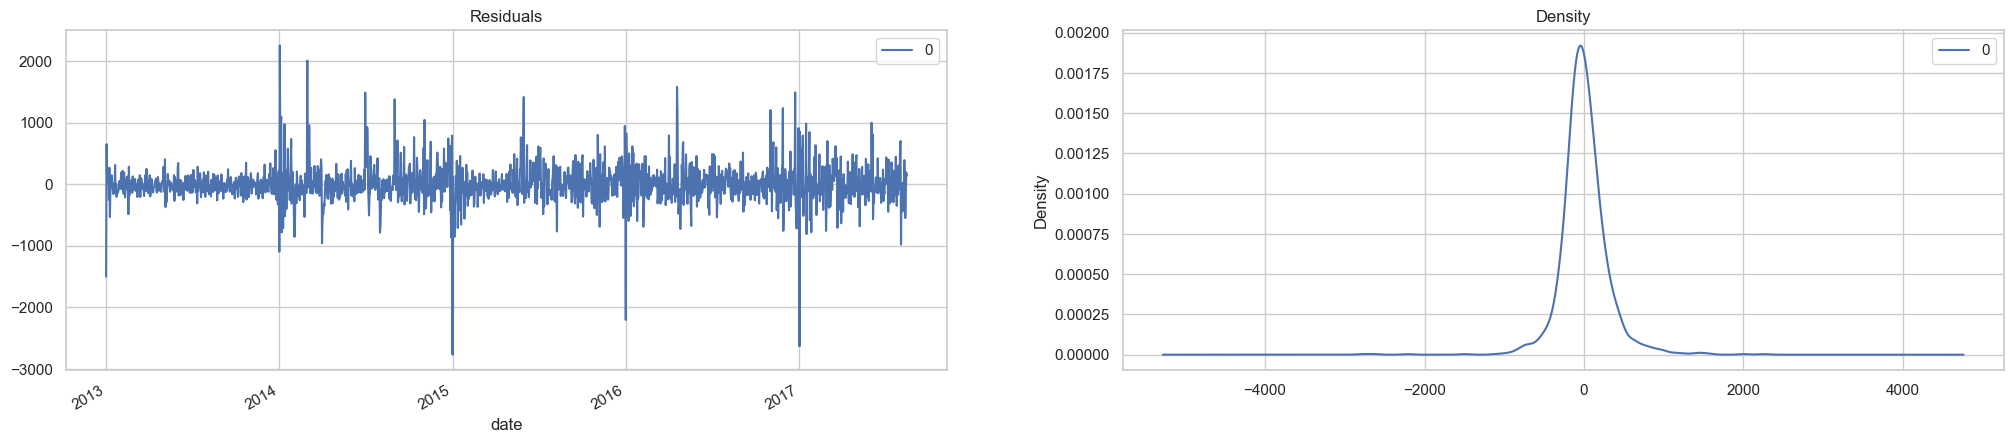

In [178]:
#plot residual errors
residuals = pd.DataFrame(mod_fit_sarima.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()             

D:\LUTFI\Anacnda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\LUTFI\Anacnda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
D:\LUTFI\Anacnda\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


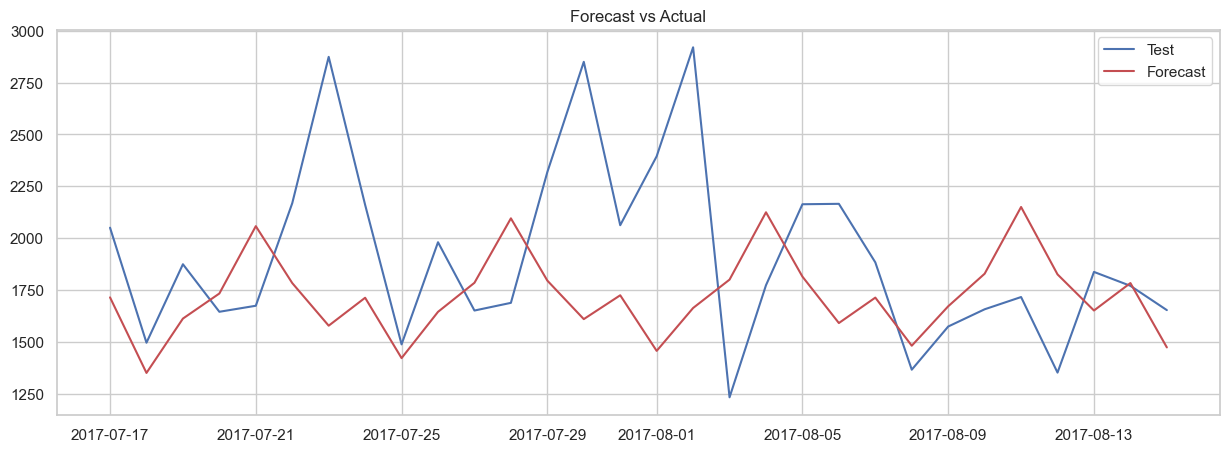

In [179]:
# Prdiction
forecast = mod_fit_sarima.predict(start=len(cal_beverage), end=len(cal_beverage)+len(test)-1, typ='levels')
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test['sales'], label='Test')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

In [180]:
# check forecast row
forecastSARIMA = pd.DataFrame({'test': test['sales'], 'forecast': forecast})
forecastSARIMA

,test,forecast
date,,
2017-07-17,2051.0,1715.290553
2017-07-18,1497.0,1351.424092
2017-07-19,1875.0,1613.229644
2017-07-20,1646.0,1734.073800
2017-07-21,1675.0,2058.391172
2017-07-22,2169.0,1784.284378
2017-07-23,2874.0,1579.041886
2017-07-24,2161.0,1713.562867
2017-07-25,1489.0,1422.833620


### Model LSTM

In [181]:
cal_beverage

,sales,onpromotion,dcoilwtico,year,month,day,dayofweek,sales_mean_7,sales_mean_30
date,,,,,,,,,
2013-01-01,0.0,0,93.14,2013,1,1,1,NaN,NaN
2013-01-02,947.0,0,93.14,2013,1,2,2,NaN,NaN
2013-01-03,847.0,0,92.97,2013,1,3,3,NaN,NaN
2013-01-04,859.0,0,93.12,2013,1,4,4,NaN,NaN
2013-01-05,912.0,0,93.12,2013,1,5,5,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2017-08-11,1717.0,11,48.81,2017,8,11,4,1790.142857,1967.333333
2017-08-12,1353.0,6,48.81,2017,8,12,5,1674.285714,1966.233333
2017-08-13,1838.0,9,48.81,2017,8,13,6,1627.428571,1959.666667


### Preprocessing Data

In [182]:
#split data
#scaling

dcoilwtico_scaler = MinMaxScaler()
sales_scaler = MinMaxScaler()
x = cal_beverage[['onpromotion', 'dcoilwtico']].copy()
y = cal_beverage['sales'].copy()

x['dcoilwtico'] = dcoilwtico_scaler.fit_transform(x['dcoilwtico'].values.reshape(-1, 1))
y = sales_scaler.fit_transform(y.values.reshape(-1, 1))

In [183]:
def load_data(X, seq_len, test_size=30):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    data = []
    
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_data = data[:-test_size]  # Exclude last 'test_size' data points for test set
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    x_test = data[-test_size:, :-1] 
    y_test = data[-test_size:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test

window = 7
x['sales'] = y
X_train, y_train, X_test, y_test = load_data(x, window,test_size=30)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1646, 7, 3) (1646,) (30, 7, 3) (30,)


### Model 3 - Bidirectional LSTM

In [186]:
#LSTM architecture
modelLSTM = Sequential()
# First LSTM layer with Dropout regularisation
modelLSTM.add(LSTM(units=50, input_shape=(window,3)))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))


# Compiling the RNN
modelLSTM.compile(optimizer='adam',loss='mse')
# Fitting to the training set
start = time.time()
history1=modelLSTM.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1)
print ('compilation time : ', time.time() - start)

Epoch 1/100
45/45 [==============================] - 4s 19ms/step - loss: 0.0493 - val_loss: 0.0113
Epoch 2/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.0099
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0165 - val_loss: 0.0096
Epoch 4/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0153 - val_loss: 0.0111
Epoch 5/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0141 - val_loss: 0.0095
Epoch 6/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0134 - val_loss: 0.0094
Epoch 7/100
45/45 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0095
Epoch 8/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0132 - val_loss: 0.0103
Epoch 9/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0127 - val_loss: 0.0097
Epoch 10/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0127 - val_loss: 0.0102
Epoch 11

In [187]:
trainPredict = modelLSTM.predict(X_train)
testPredict = modelLSTM.predict(X_test)

trainPredict = sales_scaler.inverse_transform(trainPredict)
trainY = sales_scaler.inverse_transform([y_train])
testPredict = sales_scaler.inverse_transform(testPredict)
testY = sales_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(30, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(30, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

1/1 [==============================] - 0s 19ms/step
(30, 1)
(30, 1)


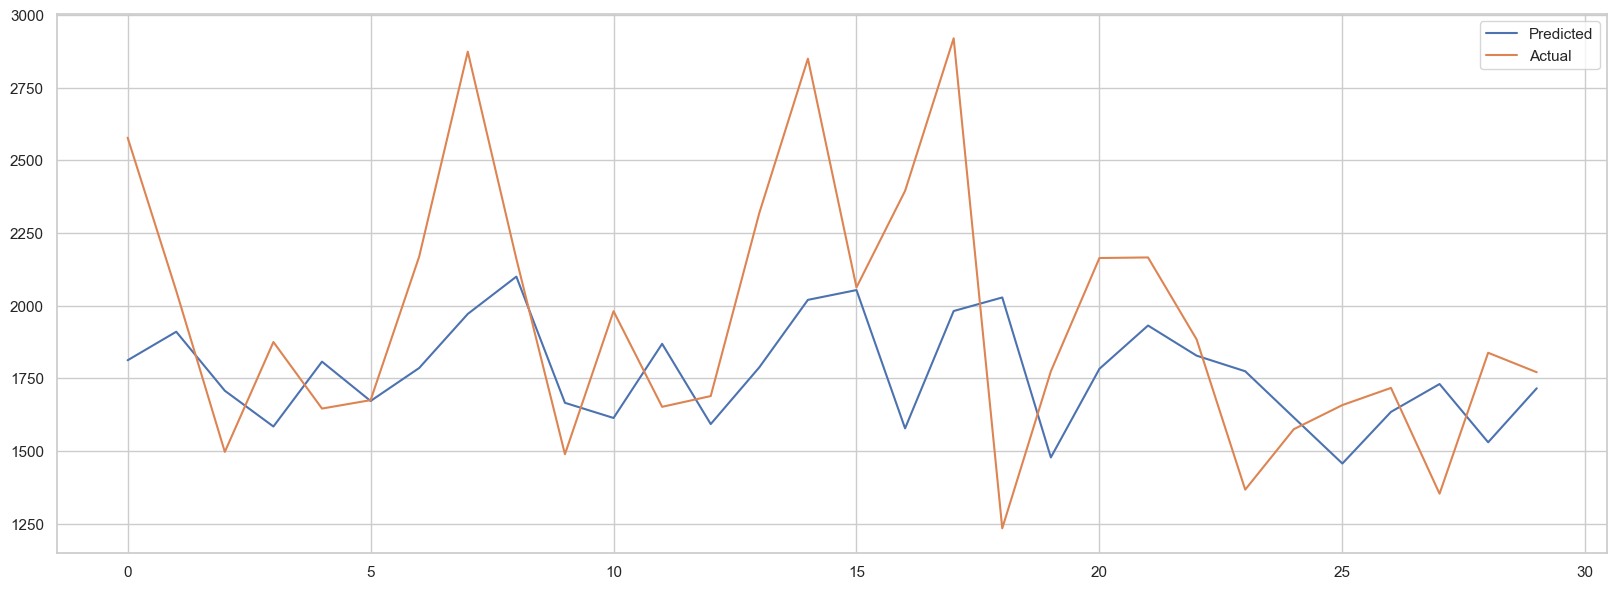

In [188]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [189]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [190]:
# Input into pandas dataframe, test as index and plot_predicted as the column
# Reshape the data plot_predicted
plot_predicted = plot_predicted.reshape(30,)

forecastLSTM = pd.DataFrame({'test': test['sales'], 'forecast': plot_predicted}, index=test.index)
forecastLSTM

,test,forecast
date,,
2017-07-17,2051.0,1812.249390
2017-07-18,1497.0,1910.356934
2017-07-19,1875.0,1707.346802
2017-07-20,1646.0,1584.266235
2017-07-21,1675.0,1807.397461
2017-07-22,2169.0,1672.103516
2017-07-23,2874.0,1785.611816
2017-07-24,2161.0,1971.608643
2017-07-25,1489.0,2099.994629


### Uji Metrik

In [191]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [192]:
model = [forecastSARIMAX, forecastSARIMA, forecastLSTM]
model_name = ['SARIMAX', 'SARIMA', 'LSTM']
metrics = []

for i in range(len(model)):
    mae = mean_absolute_error(model[i]['test'], model[i]['forecast'])
    mse = mean_squared_error(model[i]['test'], model[i]['forecast'])
    r2 = r2_score(model[i]['test'], model[i]['forecast'])
    metrics.append([mae, mse, r2])
    
metrics = pd.DataFrame(metrics, columns=['MAE', 'MSE', 'R2'], index=model_name)
metrics

,MAE,MSE,R2
SARIMAX,408.583794,283919.887156,-0.543958
SARIMA,408.583794,283919.887156,-0.543958
LSTM,374.066557,251485.802323,-0.367581
